# Cloud distribution in THAI simulations

In [1]:
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText

In [2]:
import aeolus.plot as aplt

In [3]:
# Local modules
import mypaths
from calc import (
    cloud_area_fraction,
    cloud_mmr_ice,
    cloud_mmr_liquid,
    cloud_path_total,
    cloud_volume_fraction_total,
    meridional_mean,
    spatial_mean,
)
from commons import MODELS
from names import names
from plot_func import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    darr_stats_string,
    draw_scalar,
    figsave,
    make_map_figure,
    set_alpha_in_cmap,
)

In [4]:
plt.style.use("paper.mplstyle")

## Choose case

In [5]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the time-averaged data previously preprocessed.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        model_names = names[model_key]
        ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
        if model_key in ["LMDG"]:
            lon_slice = slice(None, -1)  # omit the 180E longitude which is repeated
        else:
            lon_slice = slice(None, None)
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if model_names.x in ds[d].dims:
                vrbl = vrbl.isel(**{model_names.x: lon_slice})
            new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [7]:
VARIABLES = {
    "cwp": {
        "tex_units": "$kg$ $m^{-2}$",
        "title": "Cloud water path",
        "func": cloud_path_total,
        "method": "pcolormesh",
        "kw_plt": dict(cmap="Blues", norm=mcol.LogNorm(vmin=1e-3, vmax=1e0)),
        "kw_unit_format": dict(precision=1),
    },
    "caf": {
        "tex_units": "%",
        "title": "Cloud fraction",
        "func": cloud_area_fraction,
        "method": "contourf",
        "kw_plt": dict(cmap="Purples", levels=np.linspace(0, 100, 11)),
        "kw_unit_format": dict(precision=0),
    },
}

Saved to ../plots/Hab1__yx__cwp_caf.png
Saved to ../plots/Hab2__yx__cwp_caf.png


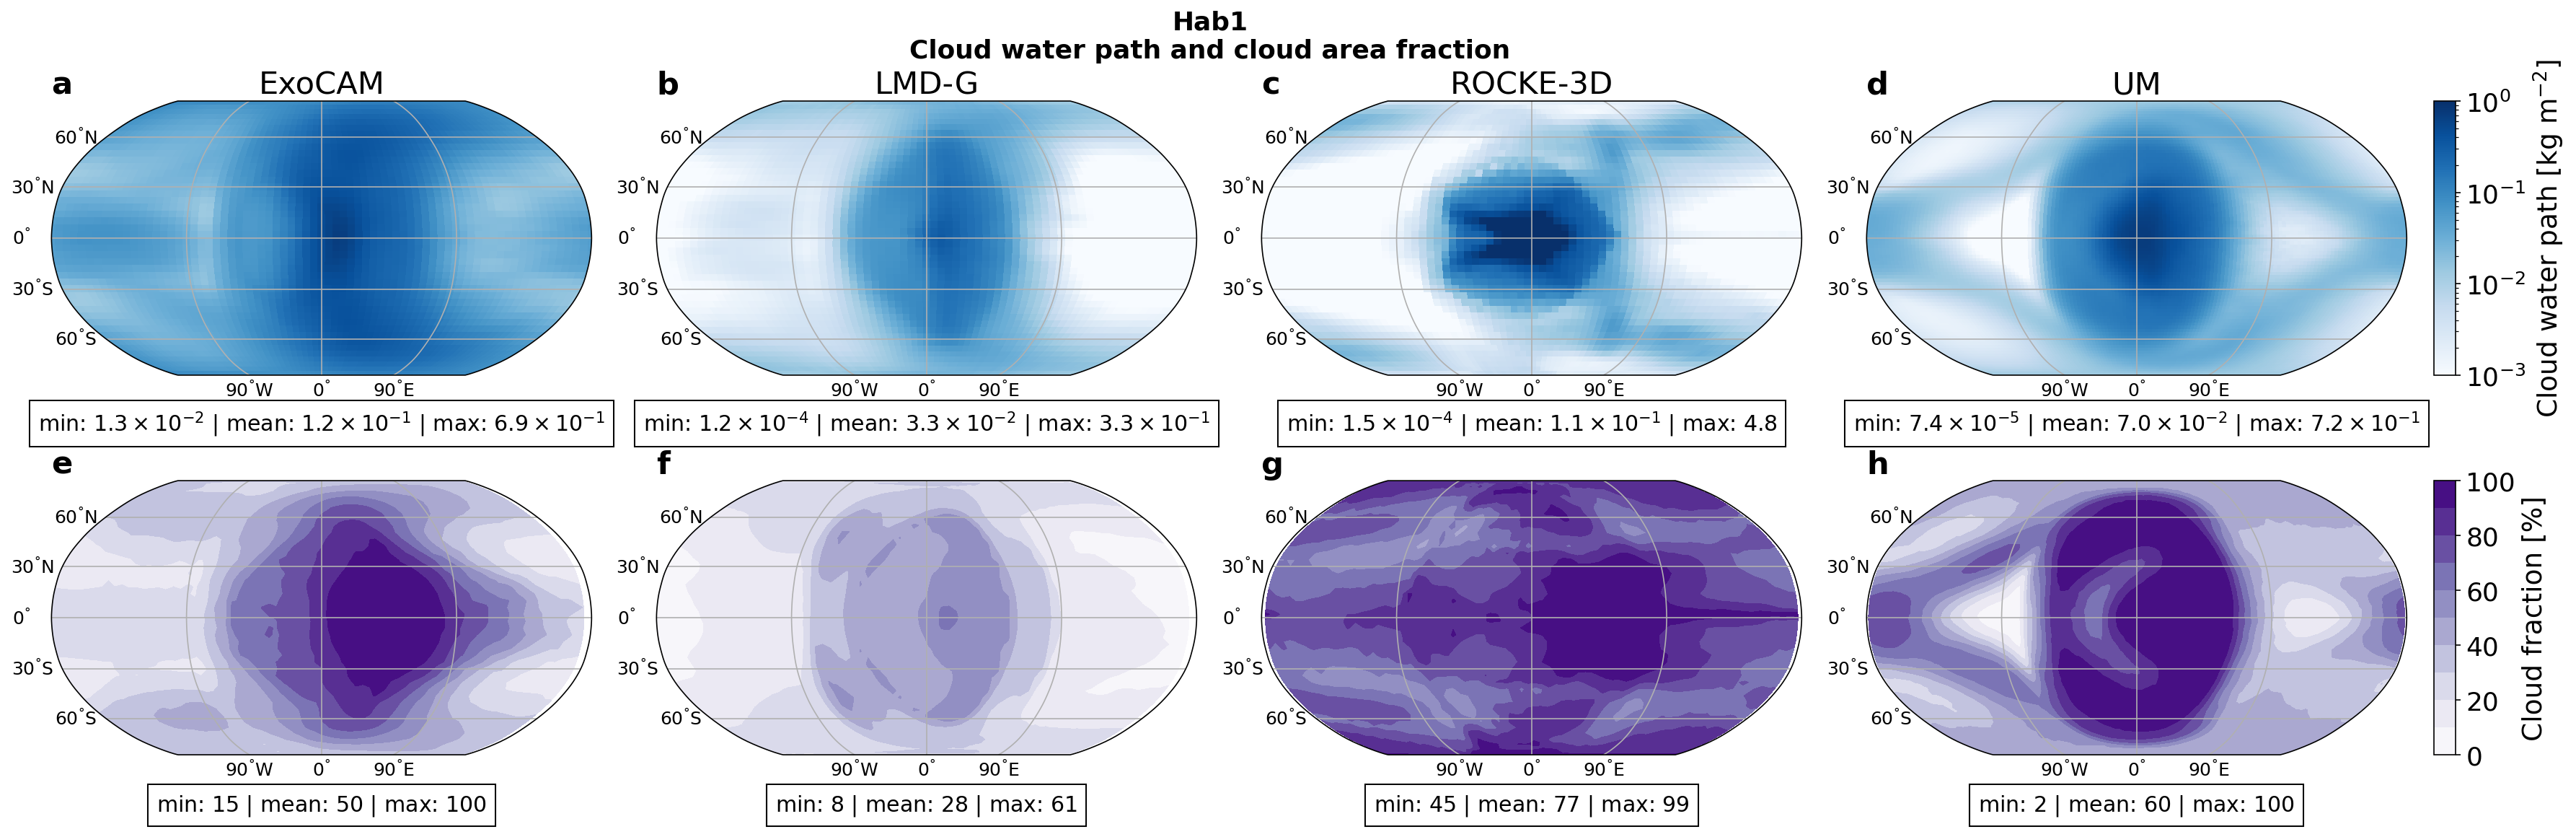

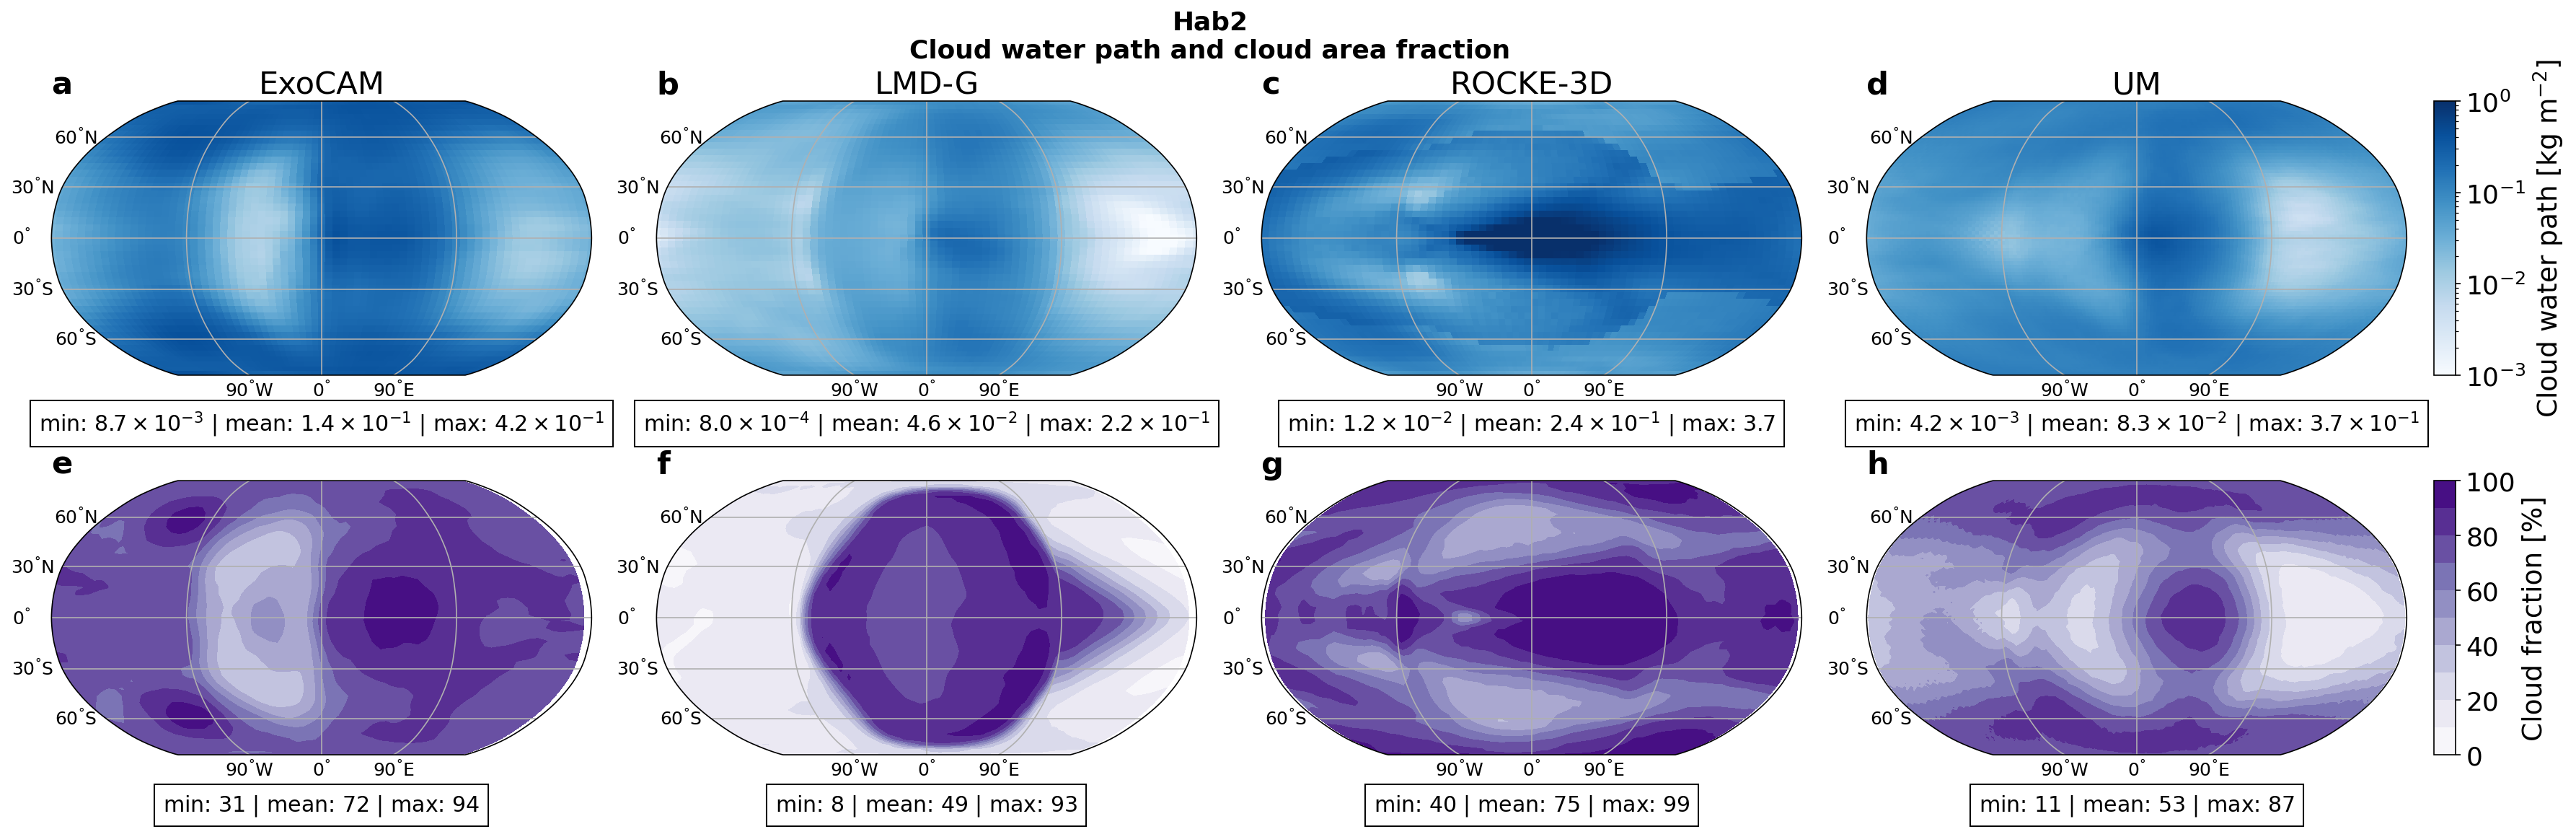

In [8]:
for THAI_case in THAI_cases:
    if THAI_case.endswith("1"):
        import const_ben1_hab1 as const
    else:
        import const_ben2_hab2 as const

    ncols = 4
    nrows = len(VARIABLES)

    fig, axgr = make_map_figure(
        ncols,
        nrows,
        axes_pad=(0.6, 0.975),
        cbar_location="right",
        cbar_mode="edge",
        cbar_pad=0.25,
        cbar_size="4%",
        label_mode="",
    )

    for ivar, ((varkey, vardict), axrow, cax) in enumerate(
        zip(VARIABLES.items(), axgr.axes_row, axgr.cbar_axes)
    ):
        for model_key, ax in zip(MODELS.keys(), axrow):
            model_names = names[model_key]
            if ivar == 0:
                ax.set_title(MODELS[model_key]["title"], **KW_MAIN_TTL)
            arr = vardict["func"](datasets[THAI_case][model_key], model_key)
            h = draw_scalar(
                arr,
                ax,
                method=vardict["method"],
                cbar_ticks=None,
                use_cyclic=False,
                model_names=model_names,
                **vardict["kw_plt"],
            )
            ax.add_artist(
                AnchoredText(
                    darr_stats_string(
                        arr,
                        model_names.x,
                        model_names.y,
                        eq_sign=": ",
                        fmt="pretty",
                        **vardict["kw_unit_format"],
                    ),
                    loc="lower center",
                    bbox_to_anchor=(0.5, -0.30),
                    bbox_transform=ax.transAxes,
                    prop={
                        "backgroundcolor": "white",
                        "color": "black",
                        "size": "large",
                    },
                )
            )
        cb = fig.colorbar(h, cax=cax, orientation="vertical")
        cb.set_label(f"{vardict['title']} [{vardict['tex_units']}]")
        cb.ax.tick_params(labelsize="x-large")
    fig.suptitle(
        f"{THAI_case}\nCloud water path and cloud area fraction",
        y=0.985,
        fontweight="bold",
        fontsize="x-large",
    )
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__yx__{'_'.join(VARIABLES.keys())}",
    )

## Vertical cross-sections

In [9]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

Saved to ../plots/Hab1__px__cld_ice_liq_mmr_cld_v.png
Saved to ../plots/Hab2__px__cld_ice_liq_mmr_cld_v.png


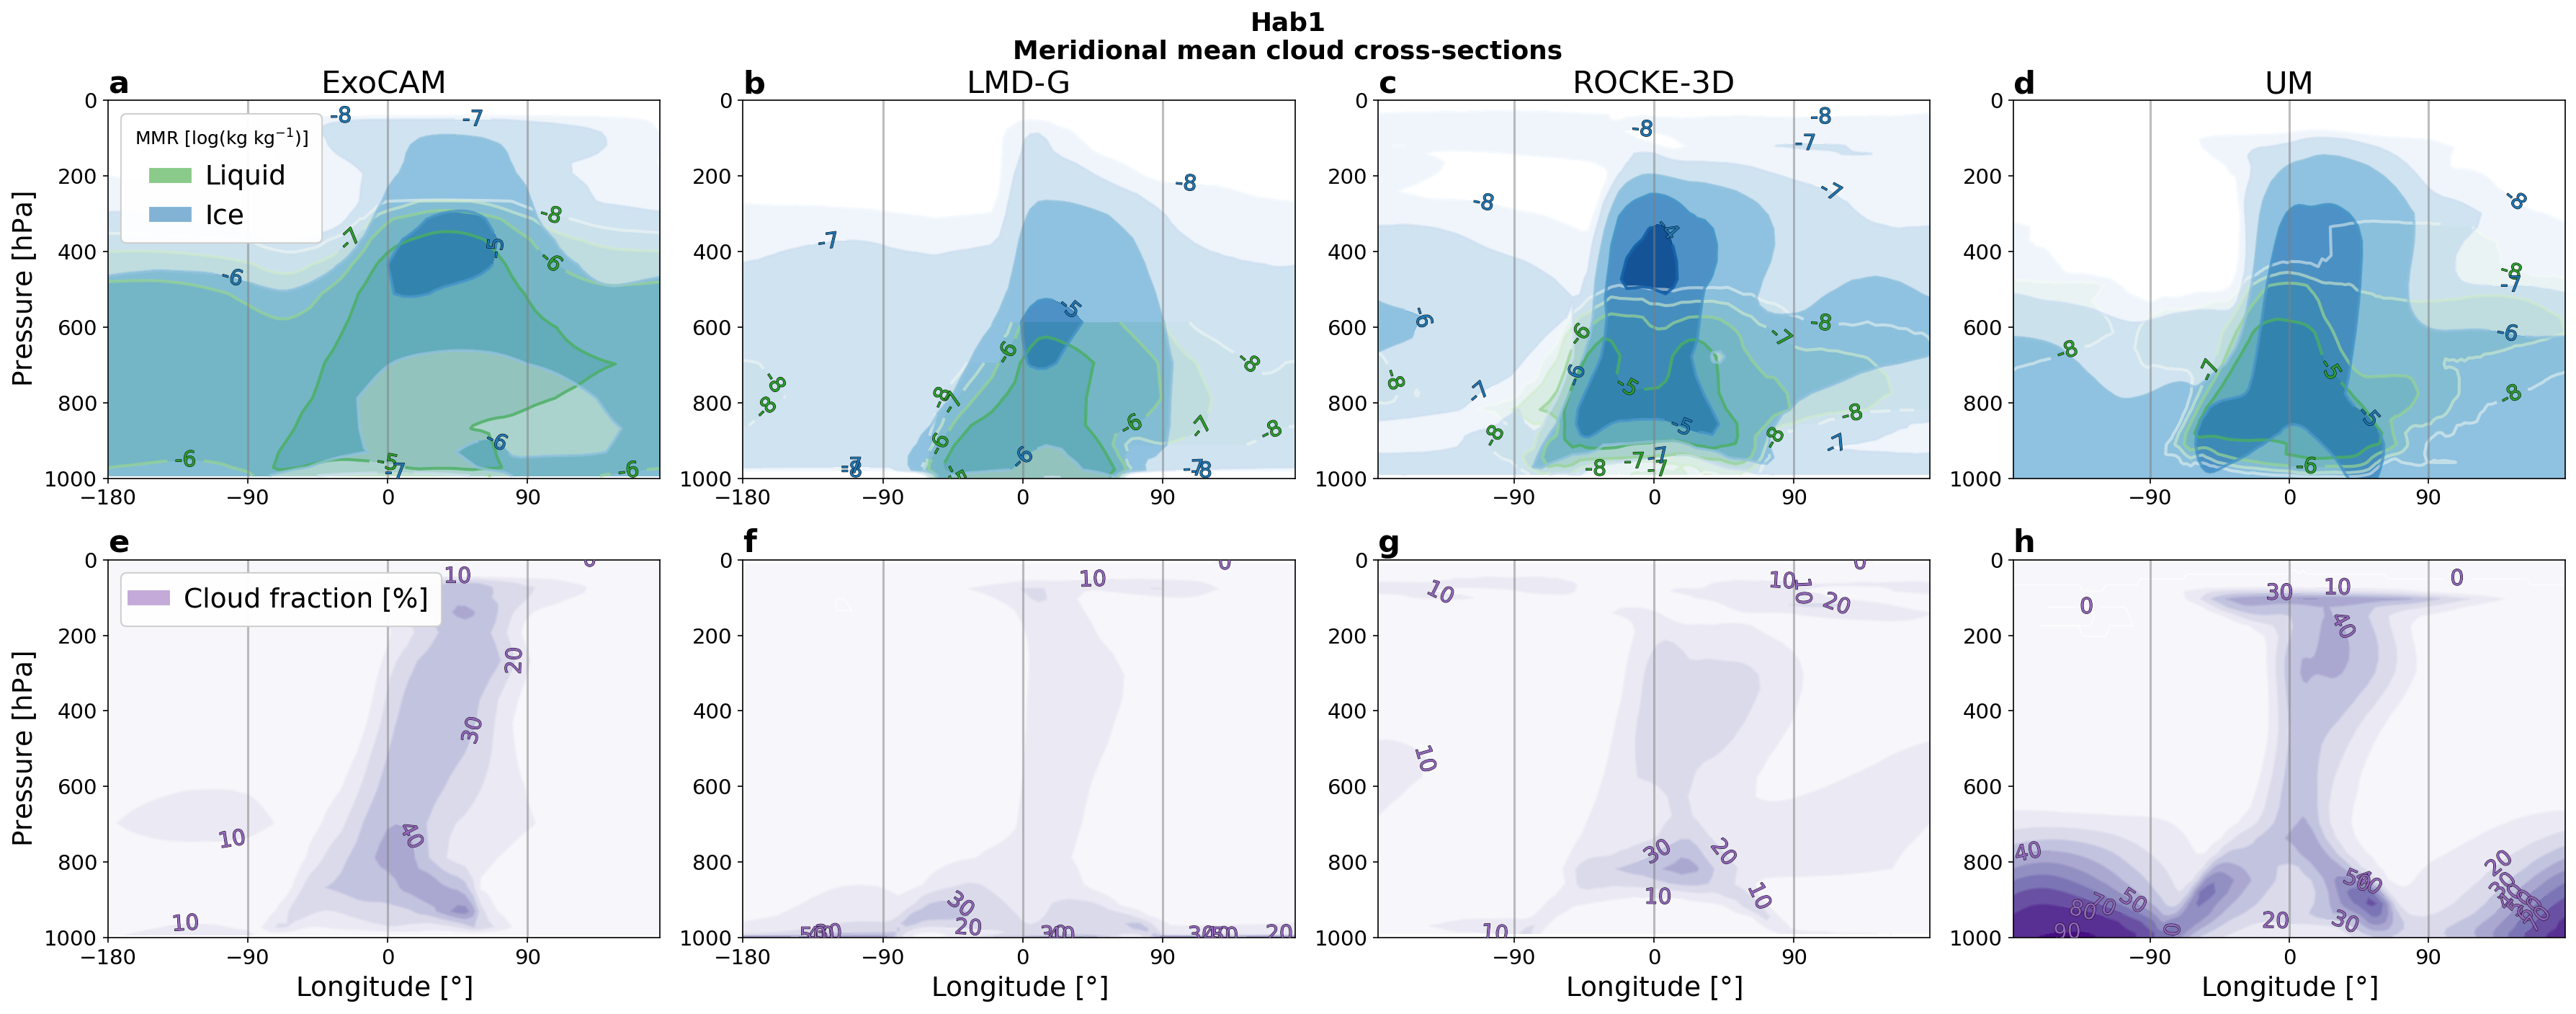

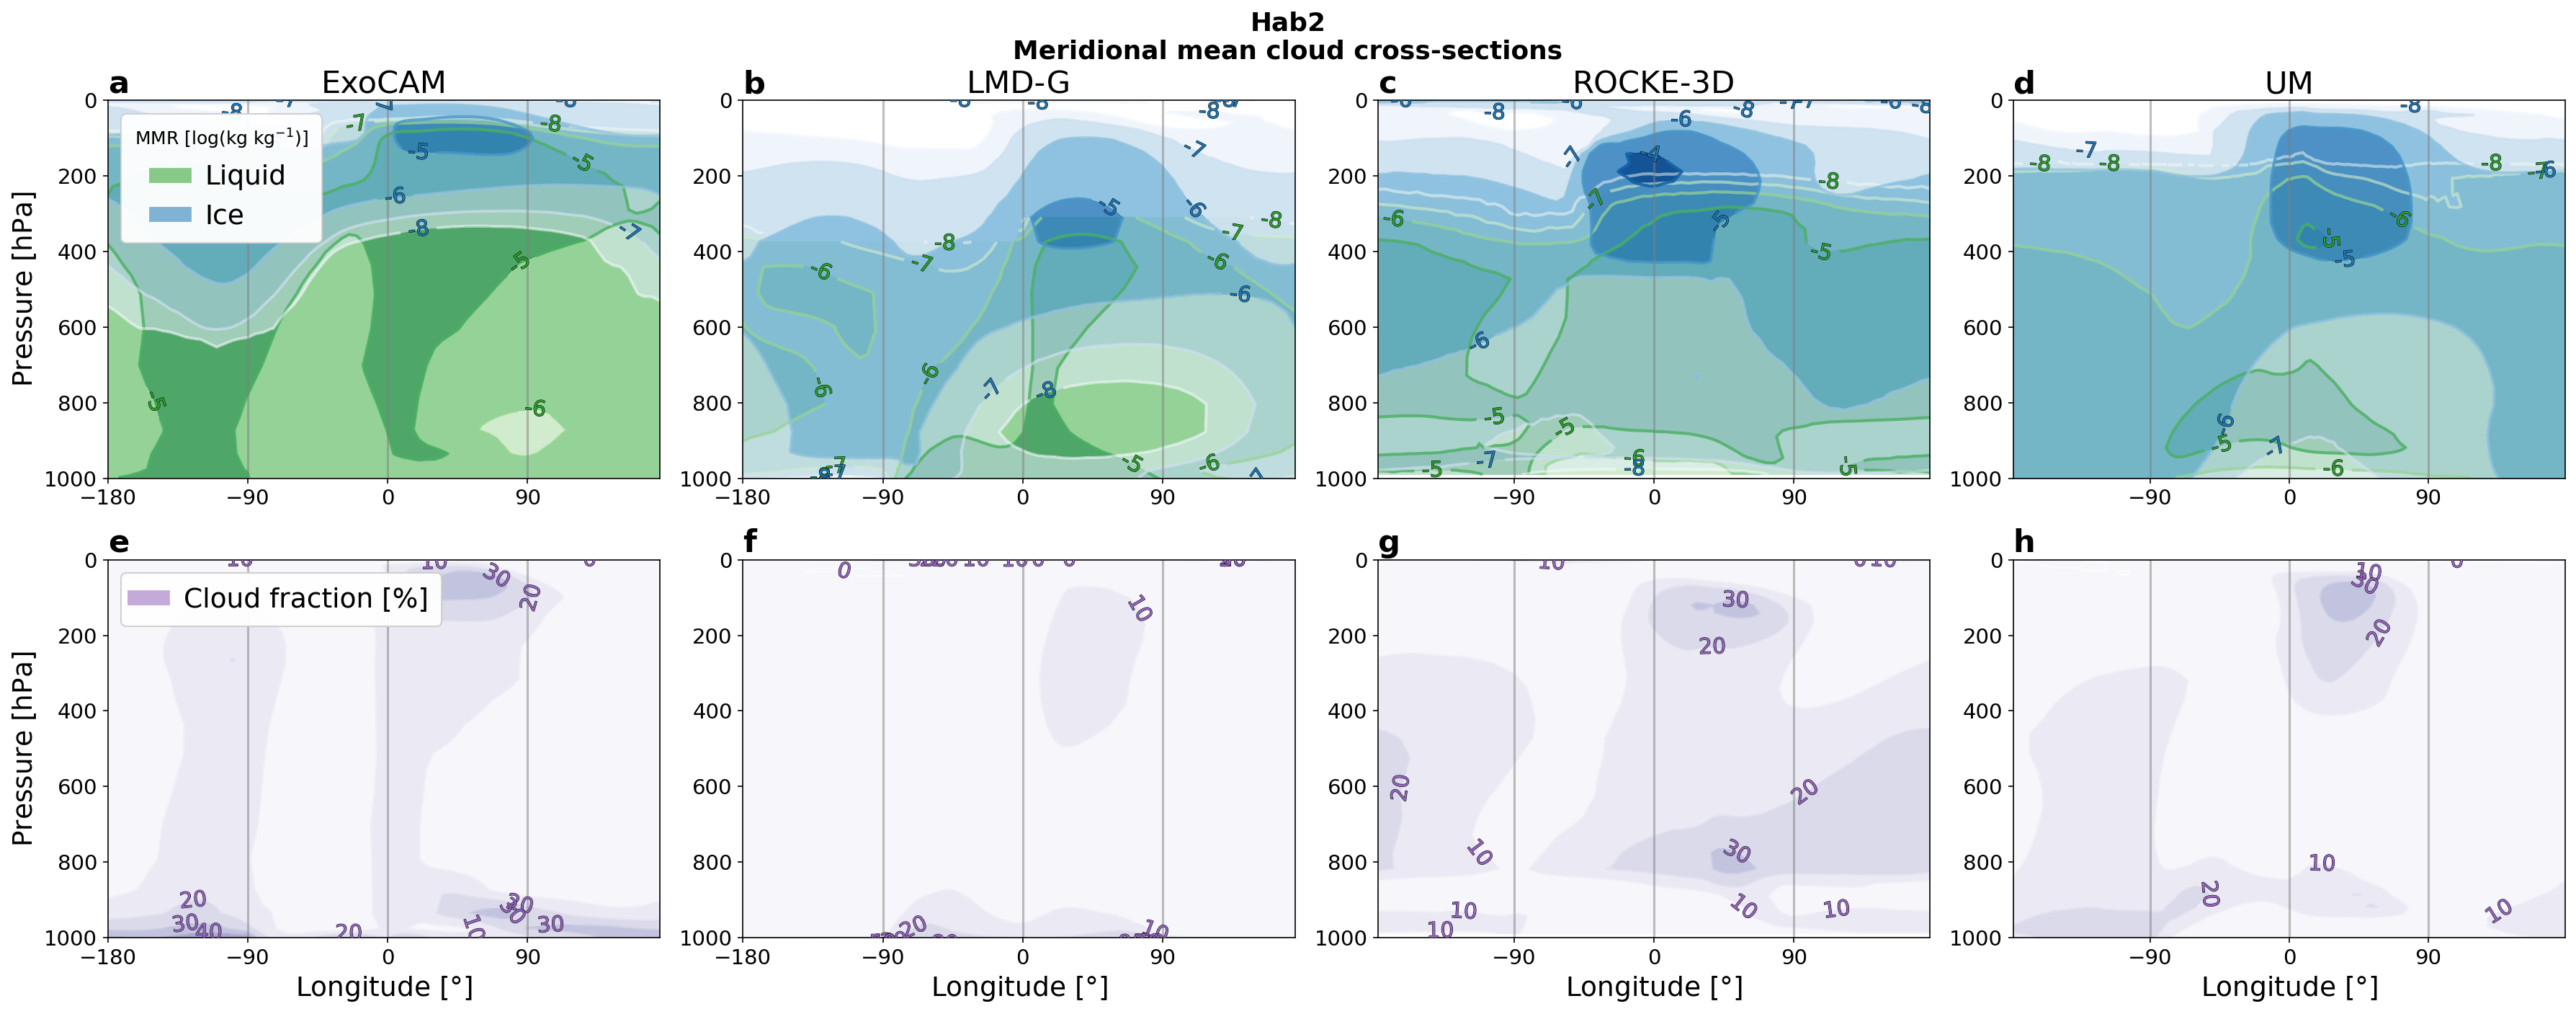

In [10]:
# reduce = lambda a: a.sel(latitude=0, method="nearest")
reduce = meridional_mean
ncols = 4
nrows = 2
for THAI_case in THAI_cases:
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 6, nrows * 4.5))
    iletters = aplt.subplot_label_generator()
    for ax in axs.flat:
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_ylim(1000, 0)
        # ax.set_yscale("log")
        ax.set_xticks(XLOCS)
        for ix in XLOCS[1:-1]:
            ax.axvline(ix, color="tab:grey", alpha=0.5)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [$hPa$]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")

    axrow = axs[0, :]
    for model_key, ax in zip(MODELS.keys(), axrow):
        model_names = names[model_key]
        ax.set_title(MODELS[model_key]["title"], **KW_MAIN_TTL)
        pres = spatial_mean(datasets[THAI_case][model_key][model_names.pres])
        if model_key != "ROCKE3D":
            # Pa to hPa
            pres /= 1e2
        lons = datasets[THAI_case][model_key][model_names.x]
        cld_liq = cloud_mmr_liquid(datasets[THAI_case][model_key], model_key)
        cld_ice = cloud_mmr_ice(datasets[THAI_case][model_key], model_key)

        for arr, levs, cmap, color in zip(
            [cld_liq, cld_ice],
            # [np.linspace(1, 10, 10), np.linspace(1, 10, 10) * 10],
            [np.linspace(-8, -3, 6), np.linspace(-8, -3, 6)],
            ["Greens", "Blues"],
            ["tab:green", "tab:blue"],
        ):
            arr = reduce(arr)
            cntrf = ax.contourf(
                lons,
                pres,
                np.log10(arr),
                cmap=set_alpha_in_cmap(cmap, 0.5),
                levels=levs,
                extend="max",
            )
            cntr = ax.contour(
                lons,
                pres,
                np.log10(arr),
                cmap=set_alpha_in_cmap(cmap, 0.5),
                levels=levs,
                extend="max",
                linewidths=2,
            )
            clbls = ax.clabel(cntr, colors=color, fmt="%.0f", fontsize="large")
            plt.setp(
                clbls,
                path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="k")],
            )
    aplt.add_custom_legend(
        axs[0, 0],
        {
            "Liquid": dict(alpha=0.5, linewidth=10, color="tab:green"),
            "Ice": dict(alpha=0.5, linewidth=10, color="tab:blue"),
        },
        loc="upper left",
        handlelength=1,
        borderpad=0.5,
        title="MMR [log($kg$ $kg^{-1}$)]",
    )

    axrow = axs[1, :]
    vardict = {
        "tex_units": "%",
        "title": "Cloud fraction",
        "func": cloud_volume_fraction_total,
        "method": "contourf",
        "kw_plt": dict(cmap="Purples", levels=np.linspace(0, 100, 11)),
    }
    for model_key, ax in zip(MODELS.keys(), axrow):
        model_names = names[model_key]
        pres = spatial_mean(datasets[THAI_case][model_key][model_names.pres])
        if model_key != "ROCKE3D":
            # Pa to hPa
            pres /= 1e2
        lons = datasets[THAI_case][model_key][model_names.x]
        arr = vardict["func"](datasets[THAI_case][model_key], model_key)
        arr = reduce(arr)

        cntrf = getattr(ax, vardict["method"])(
            lons,
            pres,
            arr,
            **vardict["kw_plt"],
        )
        cntr = ax.contour(
            lons,
            pres,
            arr,
            **vardict["kw_plt"],
            linewidths=1,
        )
        clbls = ax.clabel(cntr, colors="tab:purple", fmt="%.0f", fontsize="large")
        plt.setp(
            clbls,
            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="k")],
        )
    aplt.add_custom_legend(
        axs[1, 0],
        {
            "Cloud fraction [%]": dict(alpha=0.5, linewidth=10, color="tab:purple"),
        },
        loc="upper left",
        handlelength=1,
        borderpad=0.5,
    )
    fig.tight_layout()
    ttl = (
        "Meridional mean cloud cross-sections\n"
        # r"Top: cloud mass mixing ratio: liquid and ice [log($kg$ $kg^{-1}$)]"
        # f"\nBottom: {vardict['title'].lower()} [{vardict['tex_units']}]"
    )
    fig.suptitle(
        f"{THAI_case}\n{ttl}",
        y=1.04,
        fontweight="bold",
        fontsize="x-large",
    )
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__px__cld_ice_liq_mmr_cld_v",
    )